In [1]:
# This script evaluates the properties of host galaxies

In [2]:
#uncomment the following two lines if you run this script on a server
#import matplotlib
#matplotlib.use('Agg') # set the backend before importing pyplot


import matplotlib.pyplot as plt
import numpy as np
import time as t
from scipy import interpolate
from astropy.io import ascii
import h5py
from matplotlib import cm
import matplotlib as mpl
import astropy.units as u
from astropy.cosmology import Planck15 as Planck
import os
# this command prevents Python from multithreading 
os.environ['MKL_NUM_THREADS'] = '1' 
import sys
import time
import random
from scipy.interpolate import interp1d
import corner
from scipy import interpolate
from random import randint
from tqdm import tqdm
import pandas as pd
from IPython.display import Audio
sound_file = '../../output.wav'
from matplotlib import ticker

In [3]:
def mid_creator(bin_array):
    # this function takes as input a set of bin edges (ascending order)
    # and returns as output as array of the mid values
    bin_mid = bin_array[0:len(bin_array)-1]+\
        (bin_array[1:len(bin_array)]-bin_array[0:len(bin_array)-1])/2
    return bin_mid

In [4]:
# these parameters are for the merger rate per galaxy plot
max_lim = 1e07 # Gyr^-1
min_lim = 1e-1 # Gyr^-1

# during the sampling process, if False does not show anything
verbose_sampling = False

# during the summation process, if False does not show anything
verbose = False

# save the output printed on a txt file 
print_on_txt = False

# showing the plots ? 
do_I_show = True

# should I show a test of the sampling ? 
test_prob = False

In [5]:
"""
This function is deprecated in this version
# shift to get the EAGLE MS at the level of synthetic MS
apply_shift = False 
"""

'\nThis function is deprecated in this version\n# shift to get the EAGLE MS at the level of synthetic MS\napply_shift = False \n'

In [6]:
# merger trees parameters
snapshot = '28' # 28 corresponds to local Universe
gal_mass_min = '1E07' 
gal_mass_max = '1E12'
central_galaxy = '0' # 0 correspond to only central galaxies
sfr_min = '0.0001' 
sfr_max = '10000' 
N_galaxies = 'all'
cosmo_sim = 'EAGLE'
IMF = 'Kroupa_01'


# here I read the redshift array of the selected merger trees
[z_Eagle, all_snapshots] = np.loadtxt('merger_trees/'+cosmo_sim+'/z_mid_'+cosmo_sim+'.txt', unpack = True)
print('z_Eagle  and snapshots = \n')
for e in range(len(z_Eagle)):
    print(z_Eagle[e], int(all_snapshots[e]))

# total number of elements in EAGLE redshift array
print('total number of snapshots = ', len(z_Eagle))

print('min z_Eagle with selected snapshot = ', z_Eagle[len(z_Eagle)-1-int(snapshot)])

z_Eagle = z_Eagle[len(z_Eagle)-1-int(snapshot):len(z_Eagle)]
print('formation redshift values considered in the cosmological simulation  = ', z_Eagle)

# loading the conditional probability 
destination = 'conditional_prob/'+cosmo_sim

catalogue_filename = destination+'/Prob_'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_galaxies+'_'+snapshot+'_'+IMF+'.npz'
print('loading proability ...')
Prob = np.load(catalogue_filename)['arr_0']
print('... proability loaded')

# assign the progenitor following the distribution from the selected merger trees or random? 
# random is fiducial case
progenitor_type = 'random' # or 'EAGLE'

# merging redshift at which evaluate quantities 
# let's evaluate the MR per galaxy at each given redshift
# I have to stick to cosmological simulation redshift resolution 
z_merg = min(z_Eagle)  
print('selected merging redshift = ', z_merg,
      ' it will be the closest redshift available in the EAGLE')

z_Eagle  and snapshots = 

2.220446049250313e-16 28
0.10063853859901428 27
0.18270987272262573 26
0.270901083946228 25
0.36566856503486633 24
0.5031073093414307 23
0.615189790725708 22
0.7356296181678772 21
0.8650505542755127 20
1.0041216611862183 19
1.259331464767456 18
1.486707329750061 17
1.7369657754898071 16
2.0124101638793945 15
2.237036943435669 14
2.4784133434295654 13
3.0165045261383057 12
3.5279765129089355 11
3.983663558959961 10
4.485213756561279 9
5.03723669052124 8
5.487415313720703 7
5.97116231918335 6
7.049566268920898 5
8.074616432189941 4
8.987874984741211 3
9.993033409118652 2
15.13231086730957 1
20.00002098083496 0
total number of snapshots =  29
min z_Eagle with selected snapshot =  2.220446049250313e-16
formation redshift values considered in the cosmological simulation  =  [2.22044605e-16 1.00638539e-01 1.82709873e-01 2.70901084e-01
 3.65668565e-01 5.03107309e-01 6.15189791e-01 7.35629618e-01
 8.65050554e-01 1.00412166e+00 1.25933146e+00 1.48670733e+00
 1.7369657

In [7]:
# this must be equalt to the one of the cosmological simulation
mass_gal_min = 7 

folder_file = '../galaxy_models/galaxy_models_list.csv'
    
#here I am loading the synthetic Universe
df = pd.read_csv(folder_file,  header = 0)
variables = df.keys()
num_of_cases = len(df[variables[0]])
print('total number of cases = ',num_of_cases )

# synthetic Universe
bin_type = 'Equal_z_bins'
z_a_min = 0
z_a_max = 8
Nz = 50

mass_gal_max = 12
Ngal = 1000
GSMF_type = 'Chruslinska_2019'

# number of galaxies at each redshift bin
Nsample = 1000

SFMR_type = 'Boogaard_2018'
Ams = 0.97
Asb = '1-Ams'
sb_shift = 0.59
sigma_ms = 0.188
sigma_sb = 0.243

met_scaling_rel = 'Mannucci_2011'
Z_spread_met_scaling_rel = 0.15
solar_Z_scale = 'Caffau_11'

# passive galaxies parameters
# Passive galaxies 
SFR_min_pass = 0.0001 # 'least_SF_EAGLE' or '1e-3'
SFR_max_pass = 'MS_3sigma' # 'least_SF_MS' or 'MS_2sigma' or 'MS_3sigma'
SFR_dist = 'uniform' # no other option available 

# I generally choose Ilbert+2013 because it has a larger redshift span
passive_GSMF_type = 'Ilbert' # Ilbert gets to larger redshifts



params = [bin_type, z_a_min, z_a_max, Nz, mass_gal_min, mass_gal_max, 
        Ngal, GSMF_type, Nsample, SFMR_type , Ams,  Asb, sb_shift, 
         sigma_ms, sigma_sb, met_scaling_rel ,Z_spread_met_scaling_rel, solar_Z_scale,
         SFR_min_pass, SFR_max_pass, SFR_dist, passive_GSMF_type, IMF]

b = 0
for y in range(num_of_cases):
    if b == 0:
        index = y+1
        summing = 0
        print('y = ', y+1)
        #print('    ',' all ', '   this case')
        for i in range(len(params)):
            #print('    ',df[variables[i+2]][y], params[i])
            if df[variables[i+1]][y] == params[i]:
                summing = summing + 1
                #print(summing)
            if summing == len(params):
                print('        found index ! = M',index)
                b = 1 
                break
        if (b == 0) and (y == num_of_cases-1):
                print('no index found')
    elif b == 1:
        break

folder_out = '../galaxy_models/M'+str(index)

folder_all_in = folder_out+'/Tables/'

# Redshift bin edges.
z_hist = np.loadtxt(folder_all_in+'Redshift_bins_edges.txt')
z_mid = mid_creator(z_hist)


total number of cases =  1
y =  1
        found index ! = M 1


In [8]:
# Let's read the formation galaxy parameters
print('synthetic universe redshift array = ', z_mid)
z_max = max(z_mid)
z_max_Eagle = z_Eagle[np.argmin(abs(z_max-z_Eagle))]
print('maximum z_Eagle = ', z_max_Eagle)

#let's take the closest redshift bins to snapshot as minimum
z_min_ind = np.argmin(abs(min(z_Eagle)-z_mid))
print('max formation redshift index = ', z_min_ind, 'at z_mid = ', z_mid[z_min_ind])


# Sampled quantities
Mass_galaxies =  10**np.loadtxt(folder_all_in+'logM.txt') 
    # It is not directly used to caluclate the MRD
Mass_min = np.amin(Mass_galaxies, axis = None)
print('Mass min = ', np.log10(Mass_min))
SFR_galaxies =  10**np.loadtxt(folder_all_in+'logSFR.txt') 
    # It must be in linear scale
Z_m_galaxies =  np.loadtxt(folder_all_in+'logZ.txt')
print('Number of redshift bins = ',len(Z_m_galaxies[:,0]))
print('Number of sampled galaxies per redshift bin = ',len(Z_m_galaxies[0,:]))
N_galaxies = len(Z_m_galaxies[0,:])
bin_t = np.array(sorted(Planck.lookback_time(z_hist).value*1e09))  # in yrs using Planck15


dN_dV = np.loadtxt(folder_all_in+'dN_dV.txt', usecols = 1) 
    # This gives the number of galaxies per unit volume
    
    
ind_z_eagle = abs(z_merg-z_Eagle).argmin()
ind_z = abs(z_Eagle[ind_z_eagle]-z_mid).argmin()
print('ind_z = ',ind_z,'merging z = ', z_mid[ind_z], 'for EAGLE z = ', z_Eagle[ind_z_eagle])

if abs(z_Eagle[ind_z_eagle] - z_mid[ind_z]) > 1:
    print('Does it really mean something??? Redshift difference is too big (i.e > 1)')
    raise


Delta_t = (bin_t[len(z_mid)-ind_z]-bin_t[len(z_mid)-ind_z-1])/1e09
print('Delta t = ' , Delta_t, ' Gyr')

synthetic universe redshift array =  [7.91836735 7.75510204 7.59183673 7.42857143 7.26530612 7.10204082
 6.93877551 6.7755102  6.6122449  6.44897959 6.28571429 6.12244898
 5.95918367 5.79591837 5.63265306 5.46938776 5.30612245 5.14285714
 4.97959184 4.81632653 4.65306122 4.48979592 4.32653061 4.16326531
 4.         3.83673469 3.67346939 3.51020408 3.34693878 3.18367347
 3.02040816 2.85714286 2.69387755 2.53061224 2.36734694 2.20408163
 2.04081633 1.87755102 1.71428571 1.55102041 1.3877551  1.2244898
 1.06122449 0.89795918 0.73469388 0.57142857 0.40816327 0.24489796
 0.08163265]
maximum z_Eagle =  8.074616432189941
max formation redshift index =  48 at z_mid =  0.08163265306122458
Mass min =  7.00251280399968
Number of redshift bins =  49
Number of sampled galaxies per redshift bin =  1000
ind_z =  48 merging z =  0.08163265306122458 for EAGLE z =  2.220446049250313e-16
Delta t =  2.100324012543926  Gyr


In [9]:
# now let's read the matrix v. We need it to evaluate the MR per galaxy
# which depends on the binary formation model

obj = 'BBHs'

model = 'A5'

sigma_in = '0.14'#sys.argv[5]

n_paral = '0'

if model == 'referenceB':
    num_met = '32'
    bin_frac = '100'
else:
    num_met = '12'
    bin_frac = '50'
    
model_folder = folder_out+'/'+model+'/MRD/'

folder_all_out = folder_out+'/'+model+'/MR/'+cosmo_sim+'/'

# load matrix v and MRD - it might take some time...
[z_correct, MRD_correct] = np.loadtxt(model_folder+\
                                      obj+'/MRD_averaged_'+num_met+'Z_'+bin_frac+\
                                      '_No_'+str(sigma_in)+'_'+n_paral+'.txt'
                         , unpack = True)

print('loading the v matrix... it must be uncompressed: it may take several seconds')
#v = np.load(model_folder+\
#                   obj+'/Matrix_v_'+num_met+'Z_'+bin_frac+'_No_'+sigma_in+\
#            '_'+n_paral+'.npz')['arr_0']
hf = h5py.File(model_folder+obj+'/Matrix_v_'+num_met+'Z_'+bin_frac+'_No_'+sigma_in+\
     '_'+n_paral+'.h5', 'r')
print('finish loading')

loading the v matrix... it must be uncompressed: it may take several seconds
finish loading


In [10]:
"""
# This function is currently deprecated. 'False' single option
custom_catalogs = False
if custom_catalogs == True:
    folder_out = '../../Models/M_EAGLE'
    folder_all_in =folder_out +'/Tables/'
    # Redshift bin edges.
    z_hist = np.loadtxt(folder_all_in+'Redshift_bins_edges.txt')
    # array of redshift in descending order
    z_mid = np.loadtxt(folder_all_in+'Redshift_z_mid.txt')   
if apply_shift == True:
    # the shift is different at each redshift
    shift_array = -np.loadtxt('../../cosmo_Rate_1_model_v2/EAGLE_plots/EAGLE_shift_MS_Boco21_logM_9.txt',
                          usecols = 1)
    print('shift to be applied to the SFR of the EAGLE in dex \n ', shift_array,
         'as function of redshift')
    shift_save = 'True'
else:
    shift_array = np.zeros(len(z_Eagle))
    shift_save = '_Prob0notassigned'
"""

"\n# This function is currently deprecated. 'False' single option\ncustom_catalogs = False\nif custom_catalogs == True:\n    folder_out = '../../Models/M_EAGLE'\n    folder_all_in =folder_out +'/Tables/'\n    # Redshift bin edges.\n    z_hist = np.loadtxt(folder_all_in+'Redshift_bins_edges.txt')\n    # array of redshift in descending order\n    z_mid = np.loadtxt(folder_all_in+'Redshift_z_mid.txt')   \nif apply_shift == True:\n    # the shift is different at each redshift\n    shift_array = -np.loadtxt('../../cosmo_Rate_1_model_v2/EAGLE_plots/EAGLE_shift_MS_Boco21_logM_9.txt',\n                          usecols = 1)\n    print('shift to be applied to the SFR of the EAGLE in dex \n ', shift_array,\n         'as function of redshift')\n    shift_save = 'True'\nelse:\n    shift_array = np.zeros(len(z_Eagle))\n    shift_save = '_Prob0notassigned'\n"

In [11]:
# check if the folder exist, otherwise create it 
check_folder = os.path.isdir(folder_out+'/'+model+'/MR/')#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+model+'/MR/')
    
check_folder = os.path.isdir(folder_out+'/'+model+'/MR/'+cosmo_sim)#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+model+'/MR/'+cosmo_sim)
    
check_folder = os.path.isdir(folder_out+'/'+model+'/MR/'+cosmo_sim+'/'+obj)#+obj+'/'+snapshot)
if check_folder == False:
    print('creating folder')
    os.mkdir(folder_out+'/'+model+'/MR/'+cosmo_sim+'/'+obj)

In [12]:
# let's check if the snapshot folder exists 
# otherwise I create it 

print('I check if the snapshot folder exists:', folder_all_out+obj+'/'+snapshot)

check_folder = os.path.isdir(folder_all_out+obj+'/'+snapshot)

if check_folder == False:
    print('creating folder')
    os.mkdir(folder_all_out+obj+'/'+snapshot)
 

original_stdout = sys.stdout # Save a reference to the original standard output
#with open('filename.txt', 'w') as f:

if print_on_txt == True:
    f = open(folder_out+'/'+model+'/MR/'+cosmo_sim+'/'+obj+'/'+snapshot+'/prints.txt', 'w')
# Change the standard output to the file we created.
    sys.stdout = f

I check if the snapshot folder exists: ../galaxy_models/M1/A5/MR/EAGLE/BBHs/28


In [13]:
mass_gal_min_prob = mass_gal_min

# let's define a function that samples from the probability 
# masses bins
num_bins_form = 80 #80
num_bins_host = num_bins_form+1
Mass_gal_bins_form = np.logspace(mass_gal_min_prob, 12, num_bins_form)
Mass_gal_bins_host = np.logspace(mass_gal_min_prob, 12, num_bins_host)
Mass_gal_mid_form = mid_creator(Mass_gal_bins_form)
Mass_gal_mid_host = mid_creator(Mass_gal_bins_host)
delta_Mass_gal_bins_host =  Mass_gal_bins_host[1:len(Mass_gal_bins_host)]-\
                            Mass_gal_bins_host[0:len(Mass_gal_bins_host)-1]
# sfr bins
num_bins_sfr_form = 50 #50
num_bins_sfr_host = num_bins_sfr_form+1
sfr_gal_bins_form = np.logspace(-4,3,num_bins_sfr_form)
sfr_gal_bins_host = np.logspace(-4,3,num_bins_sfr_host)
sfr_gal_bins_form_mid =  mid_creator(sfr_gal_bins_form)
sfr_gal_bins_host_mid = mid_creator(sfr_gal_bins_host)
delta_sfr_gal_bins_host = sfr_gal_bins_host[1:len(sfr_gal_bins_host)]-\
                          sfr_gal_bins_host[0:len(sfr_gal_bins_host)-1]

max_iter = 0

def sample_mass_and_sfr(mass_form, sfr_form, z_form, #shift_array, 
                        max_iter):
    ind_z_form = np.argmin(abs(z_Eagle-z_form))
    #SFR_shift = shift_array[ind_z_form]
    ind_mass_form = np.argmin(abs(Mass_gal_mid_form-mass_form))
    sfr_in = sfr_form #10**(np.log10(sfr_form)+SFR_shift)
    ind_sfr_form = np.argmin(abs(sfr_gal_bins_form_mid-sfr_in))
    #print(ind_mass_form,ind_sfr_form,ind_z_form )
    pdf_flattened = Prob[:,:,ind_mass_form,ind_sfr_form,ind_z_form].flatten()
    # if I cannot find a Probability value I look for in the vicinity of mass_form, sfr_form, z_form
    k = 0 
    while (sum(pdf_flattened) == 0) and (k < max_iter):
        #print(ind_mass_form)
        #print(ind_sfr_form)
        #print(ind_z_form)
        k = k + 1
        #print('trial = ', k)
        walk_mass = int(np.random.normal(0,2))
        ind_mass_form_prov = ind_mass_form + walk_mass
        if ind_mass_form_prov >= len(Mass_gal_mid_form):
            ind_mass_form = ind_mass_form
        elif ind_mass_form_prov < 0:
            ind_mass_form = 0
        else:
            ind_mass_form = ind_mass_form_prov
                                
        walk_sfr = int(np.random.normal(0,2))
        ind_sfr_form_prov = ind_sfr_form + walk_sfr
        #print(ind_sfr_form_prov)
        if ind_sfr_form_prov >= len(sfr_gal_bins_form_mid):
            ind_sfr_form = ind_sfr_form 
        elif ind_sfr_form < 0:
            ind_sfr_form = 0
        else:
            ind_sfr_form = ind_sfr_form_prov
                
        walk_z = int(np.random.normal(0,0.5))
        ind_z_form_prov = ind_z_form + walk_z
        #print(ind_z_form_prov)
        if ind_z_form_prov >= len(z_Eagle):
            ind_z_form = ind_z_form 
        elif ind_z_form < 0:
            ind_z_form = 0
        else:
            ind_z_form = ind_z_form_prov     
        #print(ind_mass_form)
        #print(ind_sfr_form)
        #print(ind_z_form)
        pdf_flattened = Prob[:,:,ind_mass_form,ind_sfr_form,ind_z_form].flatten()
    
    # if still prob is not available I say it
    if sum(pdf_flattened) == 0:
        #print('no data available')
        return ['None']
        
    else:
        #print(pdf_flattened)
        prob_flattened = np.zeros(len(Mass_gal_mid_host)*len(sfr_gal_bins_host_mid))
        couples = np.zeros((len(prob_flattened),2))
        i = 0
        for j in range(len(delta_Mass_gal_bins_host)):
            for k in range(len(delta_sfr_gal_bins_host)):
                prob_flattened[i] = pdf_flattened[i]*delta_Mass_gal_bins_host[j]*\
                            delta_sfr_gal_bins_host[k]
                couples[i,0] = Mass_gal_mid_host[j]
                couples[i,1] = sfr_gal_bins_host_mid[k]
                i = i + 1
            
        ind_sampled = np.random.choice(np.arange(len(prob_flattened)), p = prob_flattened)
        
        mass_sampled = couples[ind_sampled,0]
        #sfr_sampled = 10**(np.log10(couples[ind_sampled,1])+(-1)*SFR_shift)
        sfr_sampled = couples[ind_sampled,1]
        
        return [mass_sampled, sfr_sampled]
    

    
if test_prob == True:
    # here I am testing the above defined function 
    q = 0   
    N_trials = int(1000)
    mass_trial = np.random.uniform(mass_gal_min,12)
    sfr_trial= np.random.uniform(-4,3)
    print(z_Eagle)
    #print(z_Eagle[len(z_Eagle)-int(snapshot)])
    z_trial = np.random.uniform(min(z_Eagle),max(z_Eagle))
    print('random redshift value = ', z_trial)
    for x in range(N_trials):
        if np.log10(10**sfr_trial/10**mass_trial) > -10:
            couple = sample_mass_and_sfr(10**mass_trial, 10**sfr_trial, z_trial, #shift_array,
                                         max_iter)
            if couple[0] == 'None':
                q = q + 1

            #    print('initial properties = \n', 
            #      'logM_form = ',mass_trial,'SFR_form', 10**sfr_trial, 'z_form = ', z_trial, 
            #        'log(sSFR_form) = ', np.log10(10**sfr_trial/10**mass_trial))
            #    print('no prob available')
            #else:
                #if  np.log10(couple[1]/couple[0]) > -9:
                #    print('initial properties = \n', 
                #        'logM_form = ',mass_trial,'SFR_form', 10**sfr_trial, 'z_form = ', z_trial, 
                #         'log(sSFR_form) = ', np.log10(10**sfr_trial/10**mass_trial))
                #    print('final properties = \n', 'logM_host = ',np.log10(couple[0]),
                #         'SFRhost = ',couple[1], 'log(sSFR_host) = ', np.log10(couple[1]/couple[0]))

            mass_trial = np.random.uniform(mass_gal_min,12)
            sfr_trial= np.random.uniform(-4,3)
            z_trial = np.random.uniform(0,max(z_Eagle))
        else:
            mass_trial = np.random.uniform(mass_gal_min,12)
            sfr_trial= np.random.uniform(-4,3)
            z_trial = np.random.uniform(0,max(z_Eagle))

    print('not assigned galaxies = ', q, 'over = ', N_trials)
    
    
    # here I am visualizing how good I can sample my parameter space
    N_trials = int(5000)

    q = np.ones(N_trials)*(-1)
    mass_trial = np.zeros(N_trials)
    sfr_trial= np.zeros(N_trials)
    z_trial = np.zeros(N_trials)

    for x in tqdm(range(N_trials)):
        mass_trial[x] = np.random.uniform(mass_gal_min,12)
        sfr_trial[x] = np.random.uniform(-4,3)
        z_trial[x] = np.random.uniform(0,max(z_Eagle))

        couple = sample_mass_and_sfr(10**mass_trial[x], 10**sfr_trial[x], z_trial[x], #shift_array,
                                     max_iter)

        if couple[0] == 'None':
            q[x] = 1
        else:
            continue 

    ind_q = q == 1

    print('not assigned galaxies = ', len(q[ind_q]), 'over = ', N_trials)
    
    # and making a plot of it 
    ind_non_q = (q == -1) 

    ind_q = (q == 1)

    plt.figure(figsize=(8,6))
    plt.scatter(mass_trial[ind_non_q], sfr_trial[ind_non_q], label = 'assigned', 
                color = 'blue')
    plt.scatter(mass_trial[ind_q], sfr_trial[ind_q], label = 'not assigned', 
                facecolor = "None", edgecolor = 'red', alpha = 0.1)

    plt.xlabel('log M')
    plt.ylabel('log SFR')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.title('any redshift')
    plt.legend(loc = 1)
    plt.savefig(folder_all_out+obj+'/'+snapshot+'/assignation_process.png', format = 'png'
               , facecolor='white',
           bbox_inches='tight')
    if do_I_show == True:
        plt.show()

    plt.close()


In [14]:
# load sampled indexes

# saving the sampled index at each redhsift as a compressed numpy array 
filename = '/Sampled_indexes_'+num_met+'Z_'+bin_frac+'_No_'+sigma_in+ \
    '_'+n_paral
sampled_indexes = np.load(model_folder+\
                   obj+'/'+filename+'.npz',allow_pickle=True)['arr_0']
print('loaded sampled indexes')
print('total number of redshift bins = ', len(sampled_indexes ))


loaded sampled indexes
total number of redshift bins =  49


In [15]:
# merger rate per HOST and FORMATION galaxy 
t00 = time.time() 

# initialise vectors
nGW = []
Mass_gal = []
SFR_gal = []
log_sSFR_gal = []
z_form = []

# let's check that the MRD is consistent with the one I evaluated before
MRD_check = 0

# let's also evalaute the merger rate per galaxy without merger trees
# this yields consistent results only when the delay time is very short < 20 Myr
nGW_notrees = []
Mass_gal_notrees = []
SFR_gal_notrees = []
Z_gal_notrees = []

non_assigned = 0

# here I am saving the mass and sfr of the galaxies I was not able to assign
non_assigned_mass = []
non_assigned_sfr = []
non_assigned_zform = []

# here I save the correspind assigned values, by doing this I can check the error I made
assigned_mass = []
assigned_sfr = []

count_lose = 0

Mass_gal_notassigned = 0
SFR_gal_notassigned = 0

# formation redshift that stop at the selected merger redshift
for zf in tqdm(range(ind_z+1), disable = True): 
    # let's load all the galaxies at this formation redshift
    
    print('formation redshift = ', z_mid[zf])
    
    ### let's find the closest z_Eagle formation redshift
    #z_E_ind = np.argmin(abs(z_mid[zf]-z_Eagle))
    #print('z_form = ', z_mid[zf],'closest z_Eagle = ', z_Eagle[z_E_ind])
    
    sampled_indexes_z = sampled_indexes[zf]
    #print(sampled_indexes_z)
    #print(Mass_galaxies[zf,sampled_indexes_z])
    
    v = np.array(hf.get('z_form_'+str(zf)))
    
    for i in tqdm(sampled_indexes_z): # sampled galaxies
        #print(i)
        
        summed_v = sum(v[ind_z,0,:,i]) # sum over all metalliicities
        
        # I added this condition to not waste time to assign galaxies to non-mergers
        if summed_v != 0:
            MRD_check = MRD_check + summed_v
        
            # save also the formation redshift
            z_form.append(z_mid[zf])
            nGW.append(summed_v)
            #MRD_check = MRD_check + summed_v
            # initial properties of formation galaxy
            mass_form = Mass_galaxies[zf,i]
            sfr_form = SFR_galaxies[zf,i]
            # Here I am sampling the host galaxy mass and sfr 
            couple = sample_mass_and_sfr(mass_form, sfr_form, z_mid[zf], #shift_array, 
                                         max_iter)
            if couple[0] == 'None':
                if verbose_sampling == True:
                    print('    conditional prob not defined, logMform =  ', 
                      round(np.log10(Mass_galaxies[zf,i]),2),
                     '\n properties of host galaxy assumed the same as the formation galaxy')

                #if I cannot assign the galaxy I don't assign galaxy               
                Mass_gal.append(0)
                SFR_gal.append(0)
                log_sSFR_gal.append(np.log10(SFR_galaxies[zf,i]/Mass_galaxies[zf,i]))
                non_assigned = non_assigned + 1
                non_assigned_mass.append(Mass_galaxies[zf,i])
                non_assigned_sfr.append(SFR_galaxies[zf,i])
                assigned_mass.append(0)
                assigned_sfr.append(0)
                non_assigned_zform.append(z_mid[zf])  
            
            
            
            else:                
                Mass_gal.append(couple[0])
                SFR_gal.append(couple[1])
                log_sSFR_gal.append(np.log10(couple[1]/couple[0]))
                # I can do this because Mass and SFR are sorted
                Mass_gal_notassigned = couple[0]
                SFR_gal_notassigned = couple[1]
            

            # same quantities as before but with no trees, 
            # thus the properties of the host galaxy are the same of the formation galaxy            
            nGW_notrees.append(summed_v)
            Mass_gal_notrees.append(Mass_galaxies[zf,i])
            SFR_gal_notrees.append(SFR_galaxies[zf,i])
            Z_gal_notrees.append(Z_m_galaxies[zf,i])
            
        else:
            continue 
    
t11 = time.time()
tt = t11-t00
print('total time for ',N_galaxies, ' galaxies = ', tt/60, ' minutes' )

print('losing mass for ',count_lose, ' galaxies ')



formation redshift =  7.918367346938775


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 132.16it/s]


formation redshift =  7.755102040816326


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 160.61it/s]


formation redshift =  7.591836734693878


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 148.11it/s]


formation redshift =  7.428571428571429


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 90.24it/s]


formation redshift =  7.26530612244898


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 141.51it/s]


formation redshift =  7.1020408163265305


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 151.00it/s]


formation redshift =  6.938775510204081


100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 150.42it/s]


formation redshift =  6.775510204081633


100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 153.13it/s]


formation redshift =  6.612244897959184


100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 105.38it/s]


formation redshift =  6.448979591836735


100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 132.88it/s]


formation redshift =  6.285714285714286


100%|██████████████████████████████████████████| 46/46 [00:00<00:00, 131.10it/s]


formation redshift =  6.122448979591836


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 102.95it/s]


formation redshift =  5.959183673469388


100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 129.47it/s]


formation redshift =  5.795918367346939


100%|██████████████████████████████████████████| 57/57 [00:00<00:00, 124.34it/s]


formation redshift =  5.63265306122449


100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 77.33it/s]


formation redshift =  5.469387755102042


100%|███████████████████████████████████████████| 63/63 [00:00<00:00, 91.68it/s]


formation redshift =  5.306122448979592


100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 127.54it/s]


formation redshift =  5.142857142857143


100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 141.47it/s]


formation redshift =  4.979591836734694


100%|██████████████████████████████████████████| 78/78 [00:00<00:00, 147.94it/s]


formation redshift =  4.816326530612245


100%|██████████████████████████████████████████| 90/90 [00:00<00:00, 145.06it/s]


formation redshift =  4.653061224489796


100%|████████████████████████████████████████| 106/106 [00:00<00:00, 162.75it/s]


formation redshift =  4.4897959183673475


100%|████████████████████████████████████████| 122/122 [00:00<00:00, 159.23it/s]


formation redshift =  4.326530612244898


100%|████████████████████████████████████████| 138/138 [00:00<00:00, 153.13it/s]


formation redshift =  4.163265306122449


100%|████████████████████████████████████████| 155/155 [00:01<00:00, 138.84it/s]


formation redshift =  4.0


100%|████████████████████████████████████████| 171/171 [00:01<00:00, 126.74it/s]


formation redshift =  3.8367346938775513


100%|████████████████████████████████████████| 187/187 [00:01<00:00, 129.53it/s]


formation redshift =  3.6734693877551026


100%|████████████████████████████████████████| 203/203 [00:01<00:00, 122.21it/s]


formation redshift =  3.5102040816326534


100%|████████████████████████████████████████| 220/220 [00:01<00:00, 118.62it/s]


formation redshift =  3.3469387755102042


100%|████████████████████████████████████████| 246/246 [00:01<00:00, 126.25it/s]


formation redshift =  3.1836734693877555


100%|████████████████████████████████████████| 273/273 [00:02<00:00, 128.42it/s]


formation redshift =  3.020408163265307


100%|████████████████████████████████████████| 299/299 [00:02<00:00, 145.07it/s]


formation redshift =  2.8571428571428577


100%|████████████████████████████████████████| 323/323 [00:02<00:00, 126.34it/s]


formation redshift =  2.6938775510204085


100%|████████████████████████████████████████| 338/338 [00:02<00:00, 126.63it/s]


formation redshift =  2.5306122448979593


100%|████████████████████████████████████████| 345/345 [00:02<00:00, 126.89it/s]


formation redshift =  2.3673469387755106


100%|████████████████████████████████████████| 348/348 [00:02<00:00, 125.93it/s]


formation redshift =  2.204081632653062


100%|████████████████████████████████████████| 363/363 [00:02<00:00, 129.96it/s]


formation redshift =  2.0408163265306127


100%|████████████████████████████████████████| 420/420 [00:03<00:00, 123.99it/s]


formation redshift =  1.8775510204081636


100%|████████████████████████████████████████| 476/476 [00:03<00:00, 122.87it/s]


formation redshift =  1.7142857142857149


100%|████████████████████████████████████████| 512/512 [00:04<00:00, 125.56it/s]


formation redshift =  1.5510204081632661


100%|████████████████████████████████████████| 531/531 [00:04<00:00, 132.70it/s]


formation redshift =  1.387755102040817


100%|████████████████████████████████████████| 546/546 [00:04<00:00, 121.40it/s]


formation redshift =  1.2244897959183678


100%|████████████████████████████████████████| 586/586 [00:04<00:00, 125.58it/s]


formation redshift =  1.0612244897959187


100%|████████████████████████████████████████| 688/688 [00:05<00:00, 126.93it/s]


formation redshift =  0.8979591836734699


100%|████████████████████████████████████████| 755/755 [00:05<00:00, 128.87it/s]


formation redshift =  0.7346938775510212


100%|████████████████████████████████████████| 797/797 [00:06<00:00, 126.83it/s]


formation redshift =  0.5714285714285721


100%|████████████████████████████████████████| 832/832 [00:06<00:00, 129.64it/s]


formation redshift =  0.4081632653061229


100%|████████████████████████████████████████| 885/885 [00:06<00:00, 127.84it/s]


formation redshift =  0.24489795918367374


100%|████████████████████████████████████████| 949/949 [00:06<00:00, 147.43it/s]


formation redshift =  0.08163265306122458


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 137.91it/s]

total time for  1000  galaxies =  1.772422198454539  minutes
losing mass for  0  galaxies 


In [16]:
# let's check the MRD
ind_max = np.argmax(dN_dV)
V = N_galaxies/dN_dV[ind_max]
print('Volume cube length = ', V**(1/3))
print('Delta t = ', Delta_t)
MRD_check_if = MRD_check/Delta_t/V
if abs(MRD_check_if - MRD_correct[len(z_mid)-1-ind_z])>1e-1:
    print('redshift index in MRD_correct = ', len(z_mid)-1-ind_z)
    print('there is a problem check = ', MRD_check_if, ' correct MRD = ',
          MRD_correct[len(z_mid)-1-ind_z])
    raise

Volume cube length =  22.438303853966616
Delta t =  2.100324012543926


In [17]:


# let's concatenate the array 
nGW = np.concatenate([nGW])/Delta_t # in Gyr^-1
print('number of total galaxies at redshift z = ',round(z_mid[ind_z],2),' = ', len(nGW))
Mass_gal = np.concatenate([Mass_gal])
SFR_gal = np.concatenate([SFR_gal])
log_sSFR_gal = np.concatenate([log_sSFR_gal])
#print('log(sSFR_host) = \n', log_sSFR_gal )

non_assigned_mass = np.concatenate([non_assigned_mass])
non_assigned_sfr = np.concatenate([non_assigned_sfr])
non_assigned_zform = np.concatenate([non_assigned_zform])

nGW_notrees = np.concatenate([nGW_notrees])/Delta_t # in Gyr^-1
nTOT = len(nGW_notrees)
print('number of total galaxies at redshift z = ',round(z_mid[ind_z],2),' notrees = ', nTOT)
Mass_gal_notrees = np.concatenate([Mass_gal_notrees])
SFR_gal_notrees = np.concatenate([SFR_gal_notrees])
Z_gal_notrees = np.concatenate([Z_gal_notrees])

z_form = np.concatenate([z_form])

# check length of arrays
if len(nGW) != len(z_form):
    raise 'something wrong with the length of arrays'
    
print('non assigned galaxies because conditional prob was zero = ', non_assigned, ' in %', 
     non_assigned*100/nTOT)   

number of total galaxies at redshift z =  0.08  =  13686
number of total galaxies at redshift z =  0.08  notrees =  13686
non assigned galaxies because conditional prob was zero =  131  in % 0.9571825222855472


BBHs


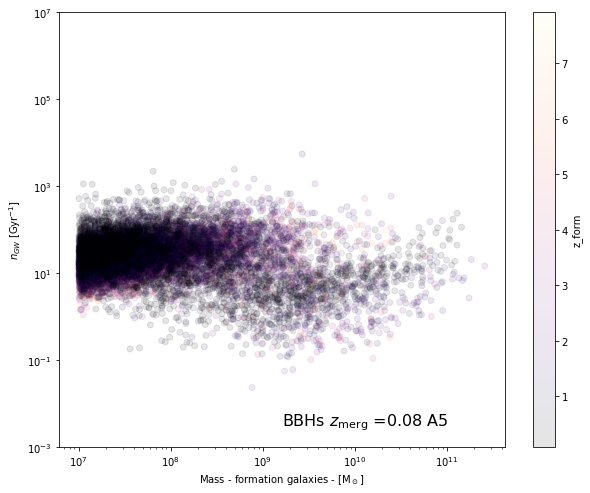

In [18]:
# plot of the merger rate per galaxy at different formation redshift
print(obj)


plt.figure(figsize = (10,8))

plt.scatter(Mass_gal_notrees, nGW_notrees, alpha = 0.1, facecolor = "None", 
            c = z_form, cmap = plt.cm.magma)
  
plt.colorbar(label = 'z_form')
plt.annotate(obj+r' $z_{\rm{merg}}$ ='+str(round(z_mid[ind_z],2))+' '+model, xy = (0.5,0.05), 
     xycoords = 'axes fraction', fontsize = 16)
plt.xlabel(r'Mass - formation galaxies - [M$_\odot$]')
plt.ylabel('$n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')
plt.xscale('log')
plt.ylim([min_lim/100,max_lim])
#plt.legend(ncol = 5, loc = 1)
plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_formation_galaxy.png',
            format = 'png'
           , facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()
plt.close()

In [19]:
print(obj)

plt.figure(figsize = (10,8))

plt.scatter(Mass_gal, nGW, alpha = 0.1,
                c = z_form, facecolor = "None",cmap = plt.cm.magma)
    
plt.colorbar(label = 'z_form')
plt.annotate(obj+r' $z_{\rm{merg}}$ ='+str(round(z_mid[ind_z],2))+' '+model, xy = (0.05,0.05), 
     xycoords = 'axes fraction', fontsize = 16)
plt.xlabel(r'Mass - host galaxies not summed - [M$_\odot$]')
plt.ylabel('$n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')
plt.xscale('log')
plt.ylim([min_lim/100,max_lim])
plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_assigned_galaxy.png', 
            format = 'png'
           , facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()
plt.close()

BBHs


In [20]:
plt.close()

fig, ax = plt.subplots(figsize = (9,6))

#print(Mass_gal)
#print(z_form)


z_hist_here = z_hist[::-1][np.arange(0,len(z_hist),1)]

Mass_gal_bins_host_here = Mass_gal_bins_host[np.arange(0,len(Mass_gal_bins_host),3)]

#print(z_hist_here)

hh = ax.hist2d(Mass_gal,z_form, bins = [Mass_gal_bins_host_here, z_hist_here], density = True,
              norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)

fig.colorbar(hh[3], ax=ax, label = 'PDF')

plt.xscale('log')


plt.xlabel('Mass - host galaxies not summed - [M$_\odot$]')
plt.ylabel(r'Formation redshift - z$_{\rm{form}}$')

plt.savefig(folder_all_out+obj+'/'+snapshot+'/Sampling_zform_Mhost.png',
            format = 'png',
            facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()

In [21]:
# not assigned galaxies 
print(obj)


plt.figure(figsize = (10,8))


plt.scatter(non_assigned_mass, non_assigned_sfr, c = non_assigned_zform,  alpha = 0.1,
            facecolor = "None",cmap = plt.cm.magma)

plt.scatter(assigned_mass, assigned_sfr, c = non_assigned_zform,  alpha = 0.1,
            facecolor = "None",cmap = plt.cm.magma, marker = 's')

plt.annotate(obj+r' $z_{\rm{merg}}$ ='+str(round(z_mid[ind_z],2))+' '+model,
             xy = (0.05,0.05), 
     xycoords = 'axes fraction', fontsize = 16)

plt.colorbar(label = 'z_form')
plt.xlabel('Mass - host galaxies not summed - [M$_\odot$]')
plt.ylabel('SFR [M$_\odot$ yr$^{-1}$]')
plt.yscale('log')
plt.xscale('log')
# this y limits are set on SFR value
plt.ylim([1e-5,1e04])
#plt.xlim([10**6.8,1e12])

plt.title('circles are where Prob = 0, while squared are the assigned galxies')

plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_notassigned_galaxy.png',
            format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()
plt.close()

BBHs


In [22]:
z_merg_ind = np.argmin(abs(z_mid-z_merg))
print(z_merg_ind)
print('merging redshift = ', z_mid[z_merg_ind])
# I need to select a subsample of galaxy in the merger redshift

# number of samples per each redshift bin such way 
# we can consider a unique comoving volume
ind_max = np.argmax(dN_dV)
N_sample_z = N_galaxies/dN_dV[ind_max]*dN_dV
print('number of samples at each redshift bin = ', N_sample_z)
# selecting a subsample of galaxies 
ind_m_z = sampled_indexes[z_merg_ind]
#print(ind_m_z)

print('merger redshift z = ', z_mid[z_merg_ind],
      'and number of glaxies = ', len(ind_m_z))

#print('chosen indexes = ', ind_m_z)
Mass_galaxies_sampled = Mass_galaxies[z_merg_ind,ind_m_z]
#print(Mass_galaxies_sampled)
SFR_galaxies_sampled = SFR_galaxies[z_merg_ind,ind_m_z]
logZ_galaxies_sampled = Z_m_galaxies[z_merg_ind,ind_m_z]

48
merging redshift =  0.08163265306122458
number of samples at each redshift bin =  [   5.00933005    9.78921664   14.56828149   19.34925132   24.13193769
   28.81184936   33.18034182   36.6003642    40.02526775   43.45449611
   46.8801489    50.28729489   53.70907025   57.13181444   60.55361771
   63.9756403    67.40213947   70.83490382   78.56386145   90.84958586
  106.39119922  122.34027301  138.64184926  155.08140433  171.50723966
  187.73414737  203.54663252  220.74363466  246.20607381  273.54952858
  299.41779503  323.59197376  338.66008658  345.49314451  348.19159573
  363.37356711  420.02555428  476.32874607  512.76732759  531.37003168
  546.98430497  586.82157315  688.85330911  755.19888889  797.01407547
  832.31468336  885.75343903  949.30397496 1000.        ]
merger redshift z =  0.08163265306122458 and number of glaxies =  1000


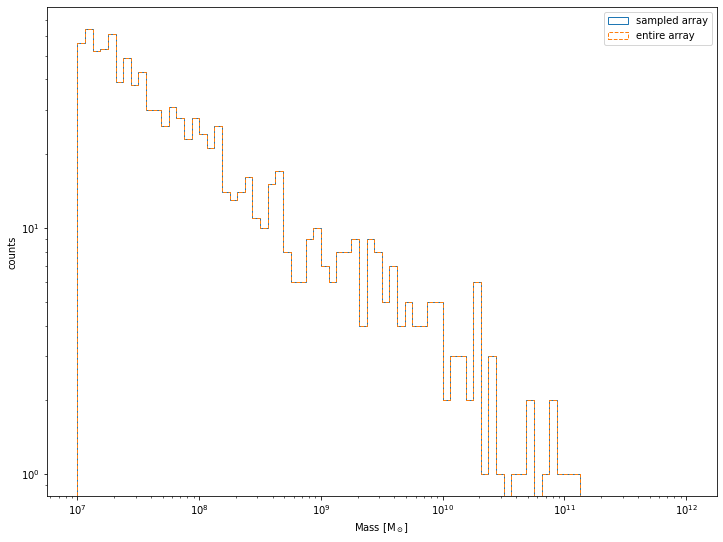

In [23]:
plt.figure(figsize=(12,9))

plt.hist(Mass_galaxies_sampled, bins = Mass_gal_bins_host, histtype = 'step', 
        label = 'sampled array')
plt.hist(Mass_galaxies[z_merg_ind,:], bins = Mass_gal_bins_host,histtype = 'step', 
        label = 'entire array', linestyle = '--')

plt.xlabel('Mass [M$_\odot$]')
plt.xscale('log')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()
if do_I_show == True:
    plt.show()
plt.close()

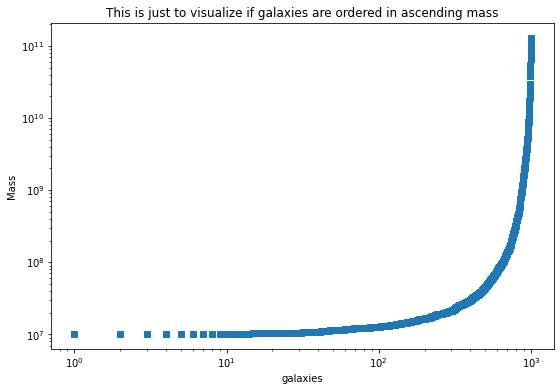

In [24]:
plt.figure(figsize=(9,6))


#ind_random = np.random.randint(0,len(Mass_galaxies_sampled),len(Mass_galaxies_sampled))

plt.plot(np.arange(len(Mass_galaxies_sampled)), Mass_galaxies_sampled#[ind_random]
         , linewidth = 0,
        marker = 's')
plt.xlabel('galaxies')
plt.ylabel('Mass')
plt.yscale('log')
plt.xscale('log')
plt.title('This is just to visualize if galaxies are ordered in ascending mass')
if do_I_show == True:
    plt.show()

In [25]:

# here I am loading the passive galaxies

folder_all_in_pass = folder_all_in+'/Passive/'
M_pass = 10**np.loadtxt(folder_all_in_pass+'/Passive_logM.txt')
SFR_pass = 10**np.loadtxt(folder_all_in_pass+'/Passive_logSFR.txt')
logZ_pass = np.loadtxt(folder_all_in_pass+'/Passive_logZ.txt')
z_mid_pass, N_pass = np.loadtxt(folder_all_in_pass+'/Passive_N.txt',
                       unpack = True)

# passive galaxies
ind_chosen = []
choices = np.arange(len(M_pass[ind_z,:]))
print('number of passive galaxies = ', N_pass[ind_z])
for j in range(int(N_pass[ind_z])):
    ind = np.random.choice(choices)
    ind_chosen.append(ind)
    choices = choices[choices != ind]


Masses_NSFR = M_pass[ind_z,ind_chosen]
SFR_NSFR = SFR_pass[ind_z,ind_chosen]
logZ_NSFR = logZ_pass[ind_z,ind_chosen]
                     


number of passive galaxies =  106.0


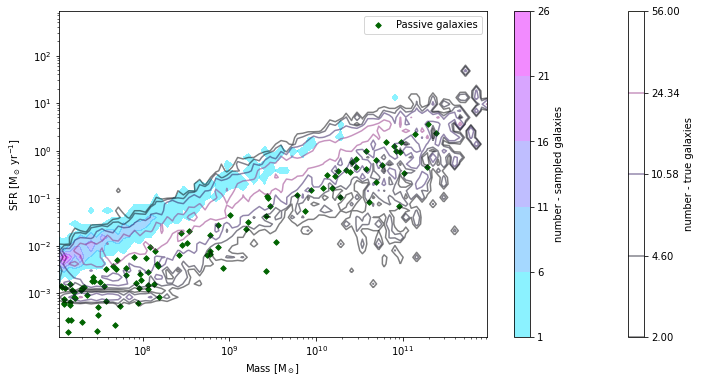

In [26]:
fig = plt.figure(figsize=(12,6))

h_sampled = np.histogram2d(Mass_gal,SFR_gal, bins = [Mass_gal_bins_host,sfr_gal_bins_host])[0]

h_local = np.histogram2d(Mass_galaxies_sampled,SFR_galaxies_sampled,
                         bins = [Mass_gal_bins_host,sfr_gal_bins_host])[0]

cs1 = plt.contour(Mass_gal_mid_host,sfr_gal_bins_host_mid, 
                  np.transpose(h_sampled), 
                levels = np.logspace(np.log10(2),
                                     np.log10(np.max(h_sampled, axis = None)),
                                     5),
                #vmin = 1, vmax = np.max(h_sampled, axis = None),
                  cmap = 'magma',
                 alpha = 0.5)

cs2 = plt.contourf(Mass_gal_mid_host,sfr_gal_bins_host_mid, np.transpose(h_local), 
               cmap= 'cool', alpha = 0.5, 
                   levels = np.arange(1,np.max(h_local, axis = None),5))
                   #vmin = 1, vmax = np.max(h_local, axis = None))

    
plt.scatter(Masses_NSFR,SFR_NSFR, alpha = 1,
           s = 15, marker = 'D', color = 'darkgreen', label = 'Passive galaxies')

plt.xscale('log')
plt.xlabel(r'Mass [M$_\odot$]')
plt.ylabel(r'SFR [M$_\odot$ yr$^{-1}$]')
plt.yscale('log')

fig.colorbar(cs1, label = 'number - true galaxies')
fig.colorbar(cs2, label ='number - sampled galaxies')


plt.legend()

plt.savefig(folder_all_out+obj+'/'+snapshot+'/Comp_sampling_synthUniverse.png', format = 'png',  
            facecolor='white',
           bbox_inches='tight')

if do_I_show == True:
    plt.show()


plt.close()

In [27]:
# summing the merger rate

# Let's use again the sampled galaxy from the GSMF
print('mean quiescent mass = ', np.mean(np.log10(Masses_NSFR)))
print('mean star forming mass = ', np.mean(np.log10(Mass_galaxies_sampled)))

# let's take in account also non-star forming galaxies
num_sfr_galaxies = len(Mass_galaxies_sampled)
print('number of star forming galaxies = ', num_sfr_galaxies)
num_passive_galaxies = len(Masses_NSFR)
print('number of passive galaxies = ', num_passive_galaxies)

mean quiescent mass =  8.728370016153141
mean star forming mass =  7.925437955145511
number of star forming galaxies =  1000
number of passive galaxies =  106


In [28]:
# here you have to define the function that extracts the number of progenitor per each true galaxy
# we have to options but there are no strong differences
# use the random option 
if progenitor_type == 'prob':
    
    # here I am reading the probability 
    Prob_perc = np.load(destination+'/Progenitor_prob/Prob_progenitors_'+cosmo_sim+'-MergerTrees_Ms'+gal_mass_min+'-'+gal_mass_max+\
                   '_SFR'+sfr_min+'-'+sfr_max+'_N'+N_Eagle+'_'+snapshot+'.npz')['arr_0']

    # here I am defining the binning of the progenitor
    bins_num_prog = np.logspace(np.log10(1), np.log10(1e5), 100)
    bins_num_prog_mid = mid_creator(bins_num_prog)
    bins_num_prog_delta = bins_num_prog[1:]-bins_num_prog[0:len(bins_num_prog)-1]
    
    def sample_progenitors(M, SFR, Prob, ind_masses_host_SF, ind_masses_merg_SF):
        
        chosen_index_SF = np.zeros(len(ind_masses_host_SF), dtype = int)
        
        ind_masses_merg_SF_local = ind_masses_merg_SF
        print('ind_masses_merg_SF_local = ',ind_masses_merg_SF_local)
        # let's sample the number of progenitor per each ind_masses_merg_SF 
        ind_prog_dist_mass = abs(Mass_gal_mid_host-M).argmin()
        ind_prog_dist_sfr = abs(sfr_gal_bins_host_mid-SFR).argmin()
        print(' logM = ', np.log10(Mass_gal_mid_host[ind_prog_dist_mass]),
             'log(sSFR) = ', np.log10(sfr_gal_bins_host_mid[ind_prog_dist_sfr]/Mass_gal_mid_host[ind_prog_dist_mass]))
        prob_sample = Prob_perc[:,ind_prog_dist_mass,ind_prog_dist_sfr]*bins_num_prog_delta
        
        if np.sum(prob_sample) != 0:
            samples = np.random.choice(bins_num_prog_mid,len(ind_masses_merg_SF),p=prob_sample)
            print('number of progenitors = ', samples)
            # now I have to renormilize the number of progenitors to one
            norm_factor = 1/np.sum(samples)
            print('index weights  = ', norm_factor*samples)
        else:
            # if probability is not defined let's take them random as usual 
            norm_factor = np.ones(len(ind_masses_merg_SF))*1/len(ind_masses_merg_SF)
            print('prob not defined')
        
        samples_local = samples
        norm_factor_local = norm_factor
        
        # now for every sampled galaxy I assign its true galaxy 
        for j in range(0,len(ind_masses_host_SF)):
                        
            if (z_form[ind_masses_host_SF][j] == z_mid[ind_z]) and (len(ind_masses_merg_SF_local)>0):
                
                #print('here', z_form[ind_masses_host_SF][j], z_mid[ind_z],'ind = ',j+1)
                ind_chosen_index = np.random.choice(np.arange(len(ind_masses_merg_SF_local)), 1,
                                                    p = norm_factor_local*samples_local)
                chosen_index_SF[j] = ind_masses_merg_SF_local[ind_chosen_index]
                ind_masses_merg_SF_local = np.delete(ind_masses_merg_SF_local,ind_chosen_index) 
                samples_local = np.delete(samples_local, ind_chosen_index) 
                norm_factor_local = 1/np.sum(samples_local)
                
            else:
                
                chosen_index_SF[j] = np.random.choice(ind_masses_merg_SF, p = norm_factor*samples)
                
              
            
        print('chosen index and frequencies = \n', 
              np.unique(chosen_index_SF, return_counts=True))
        
        return chosen_index_SF
            

elif progenitor_type == 'random':
    
    Prob_perc = 'here is not used'
    
    def sample_progenitors(M, SFR, Prob_perc, ind_masses_host_SF, ind_masses_merg_SF):
        
        chosen_index_SF = np.zeros(len(ind_masses_host_SF), dtype = int)
        ind_masses_merg_SF_local = ind_masses_merg_SF
        #print(ind_masses_merg_SF_local)
        for j in range(0,len(ind_masses_host_SF)):
            if (z_form[ind_masses_host_SF][j] == z_mid[ind_z]) and (len(ind_masses_merg_SF_local)>1):
                #print('here', z_form[ind_masses_host_SF][j], z_mid[ind_z],'ind = ',j+1)
                ind_chosen_index = np.random.choice(np.arange(len(ind_masses_merg_SF_local)))
                chosen_index_SF[j] = ind_masses_merg_SF_local[ind_chosen_index]
                ind_masses_merg_SF_local = np.delete(ind_masses_merg_SF_local,ind_chosen_index)   
            else:
                chosen_index_SF[j] = np.random.choice(ind_masses_merg_SF)
        #print('chosen index = ', chosen_index_SF)
        
        return chosen_index_SF

In [29]:
M_tot = np.concatenate([Mass_galaxies_sampled, Masses_NSFR], axis = None)
SFR_tot = np.concatenate([SFR_galaxies_sampled, SFR_NSFR], axis = None)
logZ_tot = np.concatenate([logZ_galaxies_sampled, logZ_NSFR], axis = None)

# I need this to keep track if the galaxy is SF or Passive
ID_galaxies = np.concatenate([np.ones(len(Mass_galaxies_sampled)), np.zeros(len(Masses_NSFR))],
                             axis = None)

In [30]:
# This is the right time to create the hdf5 file 
filename = '/Host_galaxies_'+num_met+'Z_'+bin_frac+'_No_'+sigma_in+ \
    '_'+n_paral+'.h5'
location = folder_all_out+obj+'/'+snapshot

hf = h5py.File(location+'/'+filename, 'w')

In [31]:
print('assignation of SF and P galaxies \n')


# This counts the total number of summed galaxies,
# it must be equal to the total number of assigned galaxies
# both star forming and passive, a check is passed 
ind_sum_TOT = 0

# with this I want to check if I am taking into account all the galaxies 
# this number must be equal to the one above
ind_sum_TOT_check  = 0

# this takes into account the rates lost in not summed galaxies
nGW_notsummed = 0

# this takes into account the rates NOT lost in summed galaxies
nGW_after_sum = 0

# this counts the total number of host galaxies
count = 0

# these counts the SF and P galaxies that do not host mergers
count_SF = 0
count_P = 0

# these counts the SF and P galaxies that host mergers
count_SF_host = 0
count_P_host = 0


# going over MASS bins
for i in range(len(Mass_gal_bins_host)-1):
    # if different from zero, it means I have already assigned SF galaxies
    # I need it to know if I have already gone throuhg SF galaxies
    # and thus I am in the SB range
    diff_SF = 0
    
    # going over SFR bins
    for y in range(len(sfr_gal_bins_host)-1):
        # here I select all true galaxies from the GSMF in the mass bin
        # and from the SFR bin - only star forming galaxies -
        # despite if they are formation galaxies of compact objects
        ind_masses_merg = \
            np.nonzero((M_tot < Mass_gal_bins_host[i+1]) &\
                (M_tot >= Mass_gal_bins_host[i]) &\
                      (SFR_tot< sfr_gal_bins_host[y+1]) &\
                       (SFR_tot >= sfr_gal_bins_host[y]))[0]  
            
        # here I select all sampled host galaxies that have to be assigned 
        # in the same mass bin and in the same SFR bin
        ind_masses_host = np.nonzero((Mass_gal < Mass_gal_bins_host[i+1]) &\
                    (Mass_gal >= Mass_gal_bins_host[i]) &\
                    (SFR_gal < sfr_gal_bins_host[y+1]) &\
                    (SFR_gal >= sfr_gal_bins_host[y]))[0]  
        
        # here I am checking that I am selecting all the galaxies withing the given bin
        ind_sum_TOT_check = ind_sum_TOT_check + len(ind_masses_host)
        
        if verbose == True:
            print('avaiable galaxies = ', 
                len(ind_masses_merg),'at log(M) = ', round(np.log10(Mass_gal_mid_host[i]),2),
                  'and log(sSFR) = ', 
                round(np.log10(sfr_gal_bins_host[y]/Mass_gal_mid_host[i]),1),
                '\n galaxy that have to be summed = ', len(ind_masses_host))
    
        # this is the case where I have to assign both SF and Passive galaxies 
        if (len(ind_masses_merg)!=0) and (len(ind_masses_host)!=0):
            if verbose == True:
                print('    summing!')
            
            chosen_index = sample_progenitors(Mass_gal_mid_host[i],
                        sfr_gal_bins_host_mid[y], Prob_perc, ind_masses_host,
                    ind_masses_merg)
            
            r = 0
            # this loop goes on the available galaxies
            ind_sum_tot = 0
            while r < len(ind_masses_merg):
                # this give the index of the galaxies to be summed together
                ind_sum = np.nonzero(abs(chosen_index - ind_masses_merg[r])<1e-15)[0]
                
                # this is a checker within this bin
                ind_sum_tot = ind_sum_tot +  len(ind_sum)
                
                # this is a overall checker
                ind_sum_TOT = ind_sum_TOT +  len(ind_sum)
                if verbose == True:
                    print('        number of summed galaxies = ',len(ind_sum), ' ', r+1)
                
                if len(ind_sum) != 0:
                    # host must be a dimensionless matrix
                    # it has 6 columns:
                    # Mass, SFR, Z, ID, z_form, nGW
                    host = np.zeros((len(nGW[ind_masses_host][ind_sum])+1,6))
            
                    M_here = M_tot[ind_masses_merg[r]]
                    SFR_here = SFR_tot[ind_masses_merg[r]]
                    logZ_here = logZ_tot[ind_masses_merg[r]]
                    ID_here = ID_galaxies[ind_masses_merg[r]]
                    if ID_here == 1:
                        count_SF_host = count_SF_host + 1
                    else: 
                        count_P_host = count_P_host + 1
                        
                    z_here = z_mid[z_merg_ind]
                    nGW_here = np.sum(nGW[ind_masses_host][ind_sum])
                    #print(nGW_here)
                    nGW_after_sum = nGW_after_sum + nGW_here
                    
                    # the first row is the host galaxy 
                    host[0,:] = [M_here, SFR_here, logZ_here, ID_here, z_here, nGW_here]
                    
                    # let's save the properties of the progenitor galaxies
                    for k in range(len(nGW[ind_masses_host][ind_sum])):
                      
                        host[k+1,:] = [Mass_gal_notrees[ind_masses_host][ind_sum][k],
                                      SFR_gal_notrees[ind_masses_host][ind_sum][k],
                                      Z_gal_notrees[ind_masses_host][ind_sum][k], 
                                       1, # all of them are star forming by definition, this ID = 1
                                      z_form[ind_masses_host][ind_sum][k],
                                      nGW_notrees[ind_masses_host][ind_sum][k]]
                        
                    # I have to save a group in the hdf5 file        
                    hf.create_dataset('Gal_n'+str(count), data=host)
                    count = count + 1
                    r = r + 1
                else:
                    r = r + 1
                    
            #print('        total number of summed galaxies = ', ind_sum_tot)
            if ind_sum_tot != len(ind_masses_host):
                print('        some galaxies are missing ')
                raise 
            
        # this is the case where I have sampled galaxies but no corresponding galaxies in the real Universe
        if (len(ind_masses_merg)==0) and (len(ind_masses_host)!=0):
            if verbose == True:
                print('   lost galaxies')
            nGW_notsummed = nGW_notsummed + np.sum(nGW[ind_masses_host])
            
        # this is the case where I don't have sampled galaxies but 
        # I have some galaxies in the real Universe, which won't be host galaxies 
        if (len(ind_masses_merg)!=0) and (len(ind_masses_host)==0):
            if verbose == True:
                print('    no host')
            r = 0
            while r < len(ind_masses_merg):
                # I save this galaxies with nGW = 0
                host = np.zeros((1,6))
            
                M_here = M_tot[ind_masses_merg[r]]
                SFR_here = SFR_tot[ind_masses_merg[r]]
                logZ_here = logZ_tot[ind_masses_merg[r]]
                ID_here = ID_galaxies[ind_masses_merg[r]]
                if ID_here == 1:
                    count_SF = count_SF + 1
                elif ID_here == 0: 
                    count_P = count_P + 1
                z_here = z_mid[z_merg_ind]
                nGW_here = 0
                    
                # the first row is the host galaxy 
                host[0,:] = [M_here, SFR_here, logZ_here, ID_here, z_here, nGW_here]
                    
                # I have to save a group in the hdf5 file 
                hf.create_dataset('Gal_n'+str(count), data=host)
                count = count + 1
                r = r + 1
    
print('done')

assignation of SF and P galaxies 

done


In [32]:
# These will be always displayed
print('total number of summed galaxies  = ', ind_sum_TOT, 'over = ',  nTOT, ' in %', 
     ind_sum_TOT/nTOT*100)
print('making some checks:')
if abs(ind_sum_TOT - nTOT)==non_assigned:
    print('total number of galaxies that have to be summed  = ', ind_sum_TOT_check, non_assigned)
    raise
else:
    print('... checks are good!')
print('number of final star forming galaxies = ', count_SF_host)
print('number of final passive galaxies = ',count_P_host)

total number of summed galaxies  =  4981 over =  13686  in % 36.39485605728482
making some checks:
... checks are good!
number of final star forming galaxies =  787
number of final passive galaxies =  84


In [33]:
# here I want to check how much mergers I am losing since I am not assign all the galaxies 
print(nGW_after_sum)

MRD_after_sum = nGW_after_sum/V
print('MRD after sum = ', MRD_after_sum ,
          ' correct = ',MRD_correct[len(z_mid)-1-ind_z])

ind_notassigned = Mass_gal == 0
nGW_notassigned = nGW[ind_notassigned]
nGW_notassigned_summed = sum(nGW_notassigned)
#print(nGW_notassigned_summed/V)
print(abs(nGW_notassigned_summed/V-MRD_correct[len(z_mid)-1-ind_z])*100/MRD_correct[len(z_mid)-1-ind_z])

print('checking if I lost some galaxy:')
if abs((nGW_notsummed/V + nGW_after_sum/V +nGW_notassigned_summed/V ) - MRD_correct[len(z_mid)-1-ind_z])>1:
    print(nGW_notsummed/V )
    print(nGW_after_sum/V)
    print(MRD_correct[len(z_mid)-1-ind_z])
    print('summing the two = ',MRD_notsummed_P/V+MRD_fromSB/V)
    raise 
else:
    print('    everything is good')

diff_MRD = abs(MRD_after_sum-MRD_correct[len(z_mid)-1-ind_z])
diff_MRD_perc = diff_MRD*100/MRD_correct[len(z_mid)-1-ind_z]

print('difference in percentage = ', diff_MRD_perc)


195329.05996219628
MRD after sum =  17.290071351270086  correct =  49.98708602625851
94.75365534667411
checking if I lost some galaxy:
    everything is good
difference in percentage =  65.41092364898503


In [34]:
# let's load the catalogs
Mass_gal_after_sum_SF = []
SFR_gal_after_sum_SF = []
Z_gal_after_sum_SF = []
Progenitor_after_sum_SF = [] 
nGW_after_sum_SF = []

Mass_gal_after_sum_P = []
SFR_gal_after_sum_P = []
Z_gal_after_sum_P = []
Progenitor_after_sum_P = []
nGW_after_sum_P = []

Mass_gal_form = []
z_form_plot = []
Mass_gal_merg = []

for c in tqdm(range(count)):
    #print('Gal_n'+str(c))
    #print('Mass, SFR, Z, ID, z_form, nGW')
    #Mass, SFR, Z, ID, z_form, nGW
    host_load = np.array(hf.get('Gal_n'+str(c)))
    #print(host_load)
    if (host_load[0,3] == 1) and (host_load[0,5] != 0):
        M_host = host_load[0,0]
        Mass_gal_after_sum_SF.append(host_load[0,0])
        SFR_gal_after_sum_SF.append(host_load[0,1])
        Z_gal_after_sum_SF.append(host_load[0,2])
        Progenitor_after_sum_SF.append(len(host_load[:,0]-1))
        nGW_after_sum_SF.append(host_load[0,5])
        ratio_cal = True
        
    elif (host_load[0,3] == 0) and (host_load[0,5] != 0):
        
        M_host = host_load[0,0]
        Mass_gal_after_sum_P.append(host_load[0,0])
        SFR_gal_after_sum_P.append(host_load[0,1])
        Z_gal_after_sum_P.append(host_load[0,2])
        Progenitor_after_sum_P.append(len(host_load[:,0]-1))
        nGW_after_sum_P.append(host_load[0,5])
        ratio_cal = True
    
    elif (host_load[0,5] == 0):
        ratio_cal = False
        continue
        
    if ratio_cal == True:
        Mass_gal_form.append(host_load[:,0])
        z_form_plot.append(host_load[:,4])
        Mass_gal_merg.append(M_host*np.ones(len(host_load[:,0])))
    
Mass_gal_form = np.concatenate(Mass_gal_form, axis = None)
Mass_gal_merg = np.concatenate(Mass_gal_merg, axis = None)
z_form_plot = np.concatenate(z_form_plot, axis = None)
    

100%|███████████████████████████████████████| 958/958 [00:00<00:00, 2853.97it/s]


In [35]:
M_ratio = Mass_gal_merg/Mass_gal_form
print(M_ratio)

z_bins = np.linspace(0,8,5)
z_bins_mid = mid_creator(z_bins)
print(z_form_plot)
#print(z_bins)
#print(z_bins_mid)
ratio_bins = np.logspace(-2,4.1,30)
ratio_bins_mid = mid_creator(ratio_bins)

fig = plt.figure(figsize=(12,6))
h_ratio = np.histogram2d(z_form_plot, M_ratio, 
                         bins = [z_bins, ratio_bins]) #, density = True )[0]
cs_ratio = plt.contourf(ratio_bins_mid, z_bins_mid,
                    h_ratio[0], 
                    #levels = np.logspace(2,5,10),
                    #vmin = 1, vmax = np.max(h_sampled, axis = None),
                    cmap = 'Blues',
                    norm=mpl.colors.LogNorm(),
                    #vmin = 1,
                    vmin = 1, vmax = 1e5,
                    alpha = 0.5)


plt.xscale('log')
plt.xlabel(r'Mass ratio [M_host/M_form]')
plt.ylabel(r'formation redshift - z')
fig.colorbar(cs_ratio, label = 'counts')
plt.savefig(folder_all_out+obj+'/'+snapshot+'/Mass_ratio.png', format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()
plt.close()

/home/santoliquido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Log scale: values of z <= 0 have been masked


[1.00000000e+00 9.43402059e-01 1.00000000e+00 ... 6.96680751e+00
 5.01752192e+03 1.29751174e+04]
[0.08163265 0.40816327 0.08163265 ... 2.04081633 1.3877551  1.2244898 ]


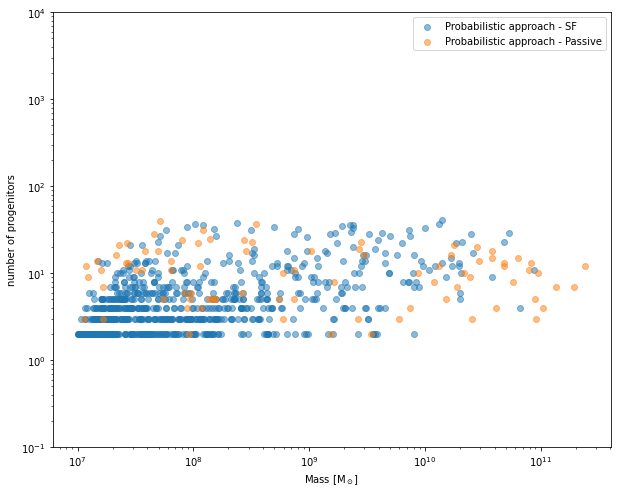

In [36]:
plt.figure(figsize=(10,8))

plt.scatter(Mass_gal_after_sum_SF, Progenitor_after_sum_SF, alpha = 0.5, 
            label = 'Probabilistic approach - SF')
plt.scatter(Mass_gal_after_sum_P, Progenitor_after_sum_P, alpha = 0.5, 
            label = 'Probabilistic approach - Passive')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Mass [M$_\odot$]')
plt.ylabel('number of progenitors')

plt.legend(loc = 1)

plt.ylim([1e-1, 1e4])


plt.savefig(folder_all_out+obj+'/'+snapshot+\
            '/number_of_progenitor_vs_mass.png', 
            format = 'png',  transparent=False, facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()
plt.close()

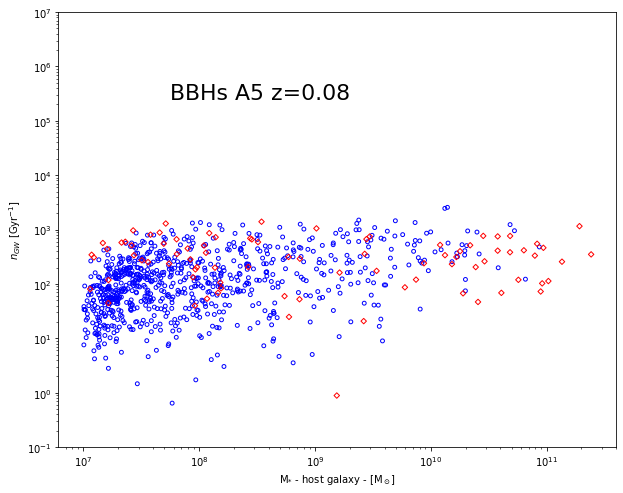

In [37]:

plt.figure(figsize = (10,8))


plt.scatter(Mass_gal_after_sum_SF, nGW_after_sum_SF,
           edgecolor = 'blue', facecolor = "None",
            #label = met_scaling_rel+' star-forming',
            s = 15)


plt.scatter(Mass_gal_after_sum_P, nGW_after_sum_P,
           edgecolor = 'red', facecolor = "None",
            #label = met_scaling_rel+' passive',
            s = 15,
           marker = 'D')




plt.annotate(obj+' '+model+' z='+str(round(z_mid[ind_z],2)), xy = (0.2,0.8), 
             xycoords = 'axes fraction', fontsize = 22)

plt.xlabel(r'M$_{*}$ - host galaxy - [M$_\odot$]')
plt.ylabel(r'$n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')
plt.xscale('log')
plt.ylim([min_lim,max_lim])
#plt.legend(ncol = 5)
plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_host_galaxy.png', format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()


plt.close()

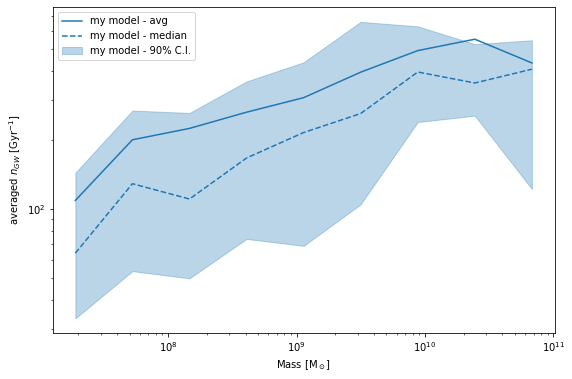

In [38]:
#plt.close()

plt.figure(figsize=(9,6))

Mass_gal_host_plot = np.logspace(7,11,10)
Mass_gal_host_plot_mid = mid_creator(Mass_gal_host_plot)

# average
nGW_avg = []
# median
nGW_med = []
# 0.25 quantile
nGW_25 = []
# 0.75 quantile
nGW_75 = []


Mass_gal_after_sum_TOT = np.concatenate([Mass_gal_after_sum_SF,Mass_gal_after_sum_P])
nGW_after_sum_TOT = np.concatenate([nGW_after_sum_SF, nGW_after_sum_P]) 

mass_plot = []

for i in range(len(Mass_gal_host_plot)-1):
    mass_indx = np.nonzero((Mass_gal_after_sum_TOT < Mass_gal_host_plot[i+1]) &\
                 (Mass_gal_after_sum_TOT >= Mass_gal_host_plot[i]))[0]  
    if len(mass_indx) == 0:
        continue 
    else:
        mass_plot.append(Mass_gal_host_plot_mid[i])
        nGW_avg.append(np.mean(nGW_after_sum_TOT[mass_indx]))
        nGW_med.append(np.quantile(nGW_after_sum_TOT[mass_indx], 0.5))
        nGW_25.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.25))
        nGW_75.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.75))
        

    
p1 = plt.plot(mass_plot, nGW_avg, label = 'my model - avg')
color_p1 = p1[0].get_color()
#print(nGW_med)
plt.plot(mass_plot, nGW_med, label = 'my model - median', color = color_p1, 
         linestyle = '--')
plt.fill_between(mass_plot, nGW_25, nGW_75, label = 'my model - 90% C.I.', color = color_p1, 
         alpha = 0.3)



plt.xlabel(r'Mass [M$_\odot$]')
plt.xscale('log')
plt.ylabel('averaged $n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')

plt.legend()

plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_host_galaxy_summed_avg.png', format = 'png', facecolor='white',
           bbox_inches='tight')

if do_I_show == True:
    plt.show()

plt.close()

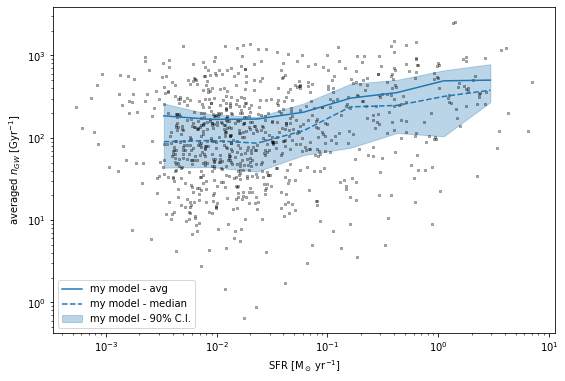

In [39]:
#plt.close()

plt.figure(figsize=(9,6))

SFR_gal_host_plot = np.logspace(-4,4,20)
SFR_gal_host_plot_mid = mid_creator(SFR_gal_host_plot)

# average
nGW_avg = []
# median
nGW_med = []
# 0.25 quantile
nGW_25 = []
# 0.75 quantile
nGW_75 = []


SFR_gal_after_sum_TOT = np.concatenate([SFR_gal_after_sum_SF,SFR_gal_after_sum_P])


SFR_plot = []
n_avg = 20
for i in range(len(SFR_gal_host_plot)-1):
    mass_indx = np.nonzero((SFR_gal_after_sum_TOT < SFR_gal_host_plot[i+1]) &\
                 (SFR_gal_after_sum_TOT >= SFR_gal_host_plot[i]))[0]  
    if len(mass_indx) < n_avg:
        continue 
    else:
        SFR_plot.append(SFR_gal_host_plot_mid[i])
        nGW_avg.append(np.mean(nGW_after_sum_TOT[mass_indx]))
        nGW_med.append(np.quantile(nGW_after_sum_TOT[mass_indx], 0.5))
        nGW_25.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.25))
        nGW_75.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.75))
        

p1 = plt.plot(SFR_plot, nGW_avg, label = 'my model - avg')
color_p1 = p1[0].get_color()
#print(nGW_med)
plt.plot(SFR_plot, nGW_med, label = 'my model - median', color = color_p1, 
         linestyle = '--')
plt.fill_between(SFR_plot, nGW_25, nGW_75, label = 'my model - 90% C.I.', color = color_p1, 
         alpha = 0.3)



plt.scatter(SFR_gal_after_sum_TOT,nGW_after_sum_TOT, s=2, marker = 's', color = 'black', 
           alpha = 0.3)


plt.xlabel(r'SFR [M$_\odot$ yr$^{-1}$]')
plt.xscale('log')
plt.ylabel('averaged $n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')

plt.legend()

plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_host_SFR_galaxy_summed_avg.png', format = 'png', facecolor='white',
           bbox_inches='tight')

if do_I_show == True:
    plt.show()

plt.close()

In [40]:
#plt.close()

plt.figure(figsize=(9,6))

sSFR_gal_host_plot = np.logspace(-12,7,50)
sSFR_gal_host_plot_mid = mid_creator(sSFR_gal_host_plot)

# average
nGW_avg = []
# median
nGW_med = []
# 0.25 quantile
nGW_25 = []
# 0.75 quantile
nGW_75 = []


sSFR_gal_after_sum_TOT = SFR_gal_after_sum_TOT/Mass_gal_after_sum_TOT


sSFR_plot = []

for i in range(len(SFR_gal_host_plot)-1):
    mass_indx = np.nonzero((sSFR_gal_after_sum_TOT < sSFR_gal_host_plot[i+1]) &\
                 (sSFR_gal_after_sum_TOT >= sSFR_gal_host_plot[i]))[0]  
    if len(mass_indx) == 0:
        continue 
    else:
        sSFR_plot.append(sSFR_gal_host_plot_mid[i])
        nGW_avg.append(np.mean(nGW_after_sum_TOT[mass_indx]))
        nGW_med.append(np.quantile(nGW_after_sum_TOT[mass_indx], 0.5))
        nGW_25.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.25))
        nGW_75.append(np.quantile(nGW_after_sum_TOT[mass_indx],0.75))
        
p1 = plt.plot(sSFR_plot, nGW_avg, label = 'my model - avg')
color_p1 = p1[0].get_color()
#print(nGW_med)
plt.plot(sSFR_plot, nGW_med, label = 'my model - median', color = color_p1, 
         linestyle = '--')
plt.fill_between(sSFR_plot, nGW_25, nGW_75, label = 'my model - 90% C.I.', color = color_p1, 
         alpha = 0.3)



plt.scatter(sSFR_gal_after_sum_TOT,nGW_after_sum_TOT, s=2, marker = 's', color = 'black', 
           alpha = 0.3)


plt.xlabel(r'sSFR [yr$^{-1}$]')
plt.xscale('log')
plt.ylabel('averaged $n_{GW}$ [Gyr$^{-1}$]')
plt.yscale('log')

plt.legend()

plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_host_sSFR_galaxy_summed_avg.png', format = 'png', facecolor='white',
           bbox_inches='tight')

if do_I_show == True:
    plt.show()

plt.close()

In [41]:
# evaluating percentage of mergers happening in passive galaxies


sSFR_TOT = np.log10(SFR_gal_after_sum_TOT/Mass_gal_after_sum_TOT)

# using Celeste's definition
ind_passive_cel = np.nonzero(sSFR_TOT < -10)[0]
                
nGW_passive_cel = np.sum(nGW_after_sum_TOT[ind_passive_cel])
            
ind_sf_cel = np.nonzero(sSFR_TOT > -10)[0]
nGW_sf_cel = np.sum(nGW_after_sum_TOT[ind_sf_cel])
            
perc_passive = nGW_passive_cel/np.sum(nGW_after_sum_TOT)*100
perc_sf = nGW_sf_cel/np.sum(nGW_after_sum_TOT)*100
            
if abs(perc_sf+perc_passive-100) > 1e-5:
    print(perc_sf+perc_passive)
    raise 
    
print('at z = ',z_merg)
print('% of merger happening in passive galaxies (sSFR < -10)\n', 
     perc_passive)
print('% of merger happening in star-forming galaxies (sSFR > -10)\n', 
     perc_sf)


at z =  2.220446049250313e-16
% of merger happening in passive galaxies (sSFR < -10)
 23.116954111605047
% of merger happening in star-forming galaxies (sSFR > -10)
 76.88304588839495


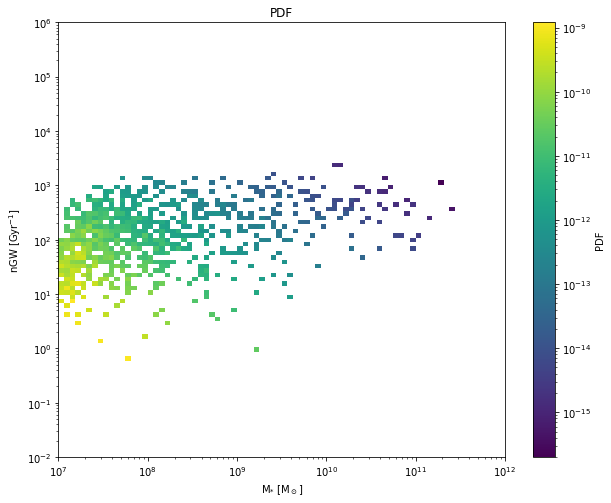

In [42]:
plt.figure(figsize=(10,8))


nGW_bins = np.logspace(-2,6,100)

Mass_gal_after_sum_all = np.concatenate([Mass_gal_after_sum_SF,Mass_gal_after_sum_P], 
                                       axis = None)
nGW_after_sum_all = np.concatenate([nGW_after_sum_SF, nGW_after_sum_P],
                                  axis = None)


plt.hist2d(Mass_gal_after_sum_all,
          nGW_after_sum_all, bins = [Mass_gal_bins_host, nGW_bins], density = True,
          norm=cm.colors.LogNorm())

plt.colorbar(label = 'PDF')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'nGW [Gyr$^{-1}$]')
plt.xlabel(r'M$_{*}$ [M$_\odot$]')
plt.title('PDF')
plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_host_galaxy_summed_PDF.png', format = 'png', facecolor='white',
           bbox_inches='tight')

if do_I_show == True:
    plt.show()
plt.close()

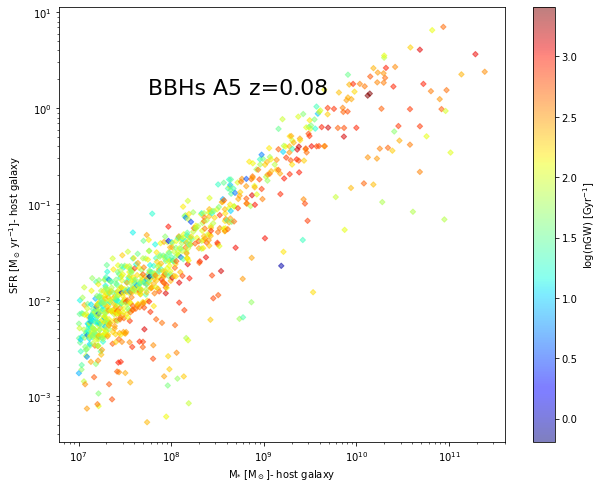

In [43]:
plt.figure(figsize = (10,8))

SFR_gal_after_sum_TOT = np.concatenate([SFR_gal_after_sum_SF,SFR_gal_after_sum_P], axis = None)
Mass_gal_after_sum_TOT = np.concatenate([Mass_gal_after_sum_SF,Mass_gal_after_sum_P], axis = None)
nGW_TOT = np.concatenate([nGW_after_sum_SF,nGW_after_sum_P], axis = None)

plt.scatter(Mass_gal_after_sum_TOT,SFR_gal_after_sum_TOT,
           c = np.log10(nGW_TOT), facecolor = "None",alpha = 0.5,
            s = 15, marker = 'D', cmap = plt.cm.jet)

plt.colorbar(label = r'log(nGW) [Gyr$^{-1}$]')

plt.annotate(obj+' '+model+' z='+str(round(z_mid[ind_z],2)), xy = (0.2,0.8), 
             xycoords = 'axes fraction', fontsize = 22)

plt.ylabel(r'SFR [M$_\odot$ yr$^{-1}$]- host galaxy')
plt.xlabel(r'M$_{*}$ [M$_\odot$]- host galaxy ')
plt.yscale('log')
plt.xscale('log')
plt.savefig(folder_all_out+obj+'/'+snapshot+'/MR_per_SFR_mass.png', format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()

plt.close()

In [44]:
def prob_cal(gal_mass, nGW, bins):
    bins_for_plot = []
    P_host = []
    bins_comp_mid = mid_creator(bins)
    p_norm = 0
    for a in tqdm(range(len(bins)-1)):
            ind_bin = np.nonzero((gal_mass < bins[a+1]) &\
                            (gal_mass >= bins[a]))[0]
            if len(ind_bin) >= 1:
                to_be_appended = sum(nGW[ind_bin])/len(ind_bin)
                P_host.append(to_be_appended)
                bins_for_plot.append(bins_comp_mid[a])  
                p_norm = p_norm + to_be_appended
            else:
                P_host.append(0)
                bins_for_plot.append(bins_comp_mid[a])  
                
    P_host = P_host/p_norm
    if abs(np.sum(P_host) - 1) > 1e-5:
        print(np.sum(P_host))
        raise
        
    return bins_for_plot, P_host

100%|████████████████████████████████████████| 49/49 [00:00<00:00, 38200.91it/s]


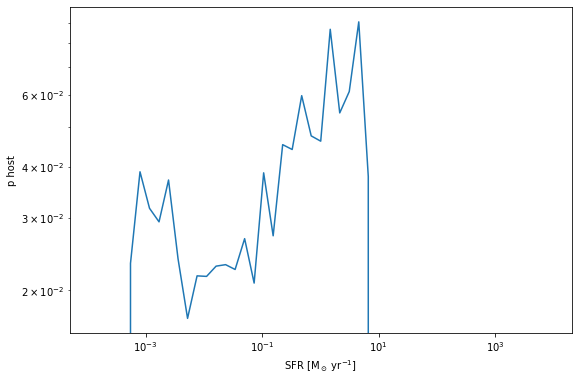

In [45]:

sfr_bins = np.logspace(-4,4,50)

bins_for_plot, p_host = prob_cal(SFR_gal_after_sum_TOT,nGW_TOT, sfr_bins)


plt.figure(figsize=(9,6))

plt.plot(bins_for_plot,p_host)

plt.yscale('log')
plt.ylabel('p host')
plt.xlabel(r'SFR [M$_\odot$ yr$^{-1}$]')
plt.xscale('log')

plt.savefig(folder_all_out+obj+'/'+snapshot+'/P_host_SFR.png', format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()

plt.close()


100%|████████████████████████████████████████| 19/19 [00:00<00:00, 24229.79it/s]


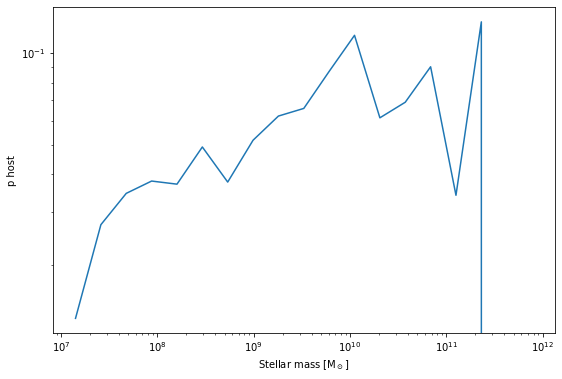

In [46]:
mass_bins = np.logspace(7,12,20)

bins_for_plot, p_host = prob_cal(Mass_gal_after_sum_TOT,nGW_TOT, mass_bins)


plt.figure(figsize=(9,6))

plt.plot(bins_for_plot,p_host)

plt.yscale('log')
plt.ylabel('p host')
plt.xlabel(r'Stellar mass [M$_\odot$]')
plt.xscale('log')

plt.savefig(folder_all_out+obj+'/'+snapshot+'/P_host_Mass.png', format = 'png', facecolor='white',
           bbox_inches='tight')
if do_I_show == True:
    plt.show()

plt.close()

In [47]:
hf.close()
if print_on_txt == True:
    f.close()
    sys.stdout = original_stdout # Reset the standard output to its original value

In [48]:
# end of galaxyRate :) ... for the moment ....